#DA 204o Data Science in Practice

Project: Online New Popularity

Authors: Rajat Chaudhary, Sonu Goyal, Srinivas Shavukapu Kattegummula, Yuvaraj G
email: rajatc@iisc.ac.in, sonugoyal@iisc.ac.in, srinivassk@iisc.ac.in, yuvarajgopi@iisc.ac.in

# 04-Modeling

## NEWS Popularity taggging

In [24]:
# 1. Calculate the News Popularity levels based on Percentiles
# 50th (Median), 95th (Top 5%), 99th (Top 1%)
p50 = np.percentile(y_train, 50)
p95 = np.percentile(y_train, 95)
p99 = np.percentile(y_train, 99)

print(f"--- DYNAMIC THRESHOLDS (Calculated from Training Data) ---")
print(f"Niche (< 50%):       0 to {int(p50):,} shares")
print(f"Performer (50-95%):  {int(p50):,} to {int(p95):,} shares")
print(f"Trending (95-99%):   {int(p95):,} to {int(p99):,} shares")
print(f"Viral (> 99%):       > {int(p99):,} shares")

--- DYNAMIC THRESHOLDS (Calculated from Training Data) ---
Niche (< 50%):       0 to 1,400 shares
Performer (50-95%):  1,400 to 10,900 shares
Trending (95-99%):   10,900 to 32,186 shares
Viral (> 99%):       > 32,186 shares


Dynamically tagging the Test and Train data with NEWS popularity

In [25]:
def preview_tier_counts(y, dataset_name="Training Set"):
    # 1. Calculate Dynamic Thresholds (Percentiles)
    # We always calculate these from the input 'y' to see the specific distribution
    p50 = np.percentile(y, 50)
    p95 = np.percentile(y, 95)
    p99 = np.percentile(y, 99)
    
    # 2. Define Bins and Labels
    # Bins: [0 to Median], [Median to 95%], [95% to 99%], [> 99%]
    bins = [-1, p50, p95, p99, np.inf]
    labels = ['Niche (Bottom 50%)', 'Performer (Top 50%)', 'Trending (Top 5%)', 'Viral (Top 1%)']
    
    # 3. Cut the data
    y_tiered = pd.cut(y, bins=bins, labels=labels)
    
    # 4. Count and Display
    counts = y_tiered.value_counts().sort_index()
    total = len(y)
    
    print(f"--- {dataset_name.upper()} DISTRIBUTION ---")
    print(f"{'TIER NAME':<25} | {'SHARE RANGE':<20} | {'COUNT':<8} | {'% OF TOTAL'}")
    print("-" * 75)
    
    # Helper to print ranges clearly
    thresholds = [0, p50, p95, p99]
    
    for i, (label, count) in enumerate(counts.items()):
        # Define the range string for display
        lower = int(thresholds[i])
        if i < 3:
            upper = int(thresholds[i+1])
            range_str = f"{lower:,} - {upper:,}"
        else:
            range_str = f"> {lower:,}"
            
        percent = (count / total) * 100
        print(f"{label:<25} | {range_str:<20} | {count:<8} | {percent:.2f}%")
    print("\n")

# Run the preview
preview_tier_counts(y_train, "Training Data")
preview_tier_counts(y_test, "Test Data")

--- TRAINING DATA DISTRIBUTION ---
TIER NAME                 | SHARE RANGE          | COUNT    | % OF TOTAL
---------------------------------------------------------------------------
Niche (Bottom 50%)        | 0 - 1,400            | 16007    | 50.47%
Performer (Top 50%)       | 1,400 - 10,900       | 14137    | 44.58%
Trending (Top 5%)         | 10,900 - 32,186      | 1253     | 3.95%
Viral (Top 1%)            | > 32,186             | 318      | 1.00%


--- TEST DATA DISTRIBUTION ---
TIER NAME                 | SHARE RANGE          | COUNT    | % OF TOTAL
---------------------------------------------------------------------------
Niche (Bottom 50%)        | 0 - 1,400            | 4075     | 51.39%
Performer (Top 50%)       | 1,400 - 10,700       | 3458     | 43.61%
Trending (Top 5%)         | 10,700 - 29,744      | 316      | 3.99%
Viral (Top 1%)            | > 29,744             | 80       | 1.01%




### Function to check model performance

In [26]:
def evaluate_model_performance(model_name, y_true, y_pred, target_names, plot_cm=True):
    """
    Robust evaluation function. 
    Automatically fixes data format issues (Probabilities -> Labels, Floats -> Ints).
    """
    
    # --- SAFETY BLOCK: FIX DATA FORMAT ---
    # Case 1: If y_pred is Probabilities (2D array), take the highest probability class
    if hasattr(y_pred, 'ndim') and y_pred.ndim > 1:
        print("⚠️ Warning: converting Probabilities to Class Labels...")
        y_pred = np.argmax(y_pred, axis=1)
        
    # Case 2: If y_pred is Float (Regressor output), round to nearest Integer
    if hasattr(y_pred, 'dtype') and np.issubdtype(y_pred.dtype, np.floating):
        print("⚠️ Warning: converting Floats to Integers...")
        y_pred = np.round(y_pred).astype(int)
        
    # --- PART 1: PRINT STATISTICS ---
    acc = accuracy_score(y_true, y_pred)
    precisions, recalls, f1s, supports = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    cm = confusion_matrix(y_true, y_pred)
    correct_counts = cm.diagonal()
    
    print("\n" + "="*95)
    print(f"PERFORMANCE REPORT: {model_name}")
    print("="*95)
    print(f"Overall Accuracy: {acc:.2%}")
    print("-" * 95)
    print(f"{'CATEGORY':<25} | {'TOTAL ACTUAL':<12} | {'CORRECT HITS':<12} | {'HIT RATE (%)':<12} | {'PRECISION':<10} | {'F1-SCORE':<10}")
    print("-" * 95)
    
    for i, name in enumerate(target_names):
        # Safety: Ensure we don't crash if confusion matrix is smaller than target_names
        if i < len(supports):
            total_actual = supports[i]
            correct_hit = correct_counts[i] if i < len(correct_counts) else 0
            hit_rate = recalls[i]
            precision = precisions[i]
            f1 = f1s[i]
            
            print(f"{name:<25} | {total_actual:<12} | {correct_hit:<12} | {hit_rate:.2%}      | {precision:.2%}     | {f1:.4f}")
        
    print("-" * 95)
    
    # --- PART 2: PLOT CONFUSION MATRIX ---
    if plot_cm:
        plt.figure(figsize=(10, 7))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names,
            annot_kws={"size": 11}
        )
        
        plt.xlabel('Predicted Tier', fontsize=12, fontweight='bold')
        plt.ylabel('Actual Tier', fontsize=12, fontweight='bold')
        plt.title(f'Confusion Matrix: {model_name}', fontsize=14)
        plt.tight_layout()
        plt.show()

target_names = ['Niche (< 50%)', 'Performer (50-95%)', 'Trending (95-99%)', 'Viral (> 99%)']

## 1. XGBoost Classifier

Training with Multi-Class AUC...
[0]	validation_0-auc:0.61695
[100]	validation_0-auc:0.68324
[200]	validation_0-auc:0.69276
[300]	validation_0-auc:0.69640
[400]	validation_0-auc:0.69894
[500]	validation_0-auc:0.69941
[600]	validation_0-auc:0.70043
[669]	validation_0-auc:0.70010

MULTI-CLASS AUC RESULTS
Weighted AUC: 0.7010 (Global Performance)
Macro AUC:    0.7025 (Treats Viral equal to Niche)
--------------------------------------------------
⚠️ Warning: converting Probabilities to Class Labels...

PERFORMANCE REPORT: XGBoost (Dynamic Tiers)
Overall Accuracy: 58.57%
-----------------------------------------------------------------------------------------------
CATEGORY                  | TOTAL ACTUAL | CORRECT HITS | HIT RATE (%) | PRECISION  | F1-SCORE  
-----------------------------------------------------------------------------------------------
Niche (< 50%)             | 4075         | 2633         | 64.61%      | 67.63%     | 0.6609
Performer (50-95%)        | 3466         | 19

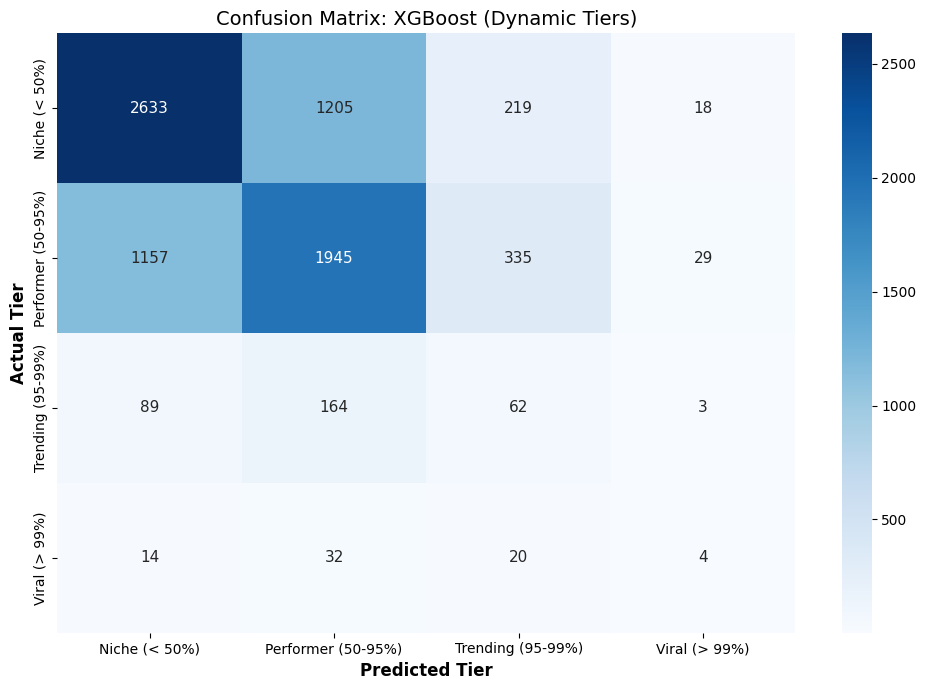

In [ ]:
# --- STEP 1: CREATE BINS ---
# Bins must cover the entire range from 0 to Infinity
bins = [-1, p50, p95, p99, float('inf')]
labels = [0, 1, 2, 3]


X_train_model = X_train.select_dtypes(include=['number'])
X_test_model = X_test.select_dtypes(include=['number'])
# Apply these specific bins to both Train and Test
y_train_dynamic = pd.cut(y_train, bins=bins, labels=labels).astype(int)
y_test_dynamic = pd.cut(y_test, bins=bins, labels=labels).astype(int)




# --- STEP 1: TRAIN WITH AUC MONITORING ---
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.11777138456676593,
    'max_depth': 4,
    'min_child_weight': 3, # Lower weight to catch rare viral hits
    'subsample': 0.6063612476638035, 'colsample_bytree': 0.8028673546901783, 'reg_alpha': 0.50990264584884, 'reg_lambda': 1.0112067447995075,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
    'objective': 'multi:softprob',
    'num_class': 4,
    
    # CRITICAL: We tell XGBoost to calculate AUC for us
    # It automatically handles the "One-vs-Rest" logic internally
    'eval_metric': 'auc', 
    'early_stopping_rounds': 50
}

print("Training with Multi-Class AUC...")
model_xgb = XGBClassifier(**xgb_params)


weights = compute_sample_weight(
    class_weight='balanced', 
    y=y_train_dynamic
)

model_xgb.fit(
    X_train_model, 
    y_train_dynamic, 
    sample_weight=weights, # Still use weights!
    eval_set=[(X_test_model, y_test_dynamic)],
    verbose=100
)

# --- STEP 2: CALCULATE AUC MANUALLY (For Report) ---
# We need probabilities, not just class labels
preds_AUC = model_xgb.predict_proba(X_test_model)

# Calculate Weighted AUC (favors the majority) and Macro AUC (favors the minority)
auc_score_weighted = roc_auc_score(
    y_test_dynamic, 
    preds_AUC, 
    multi_class='ovr', # One-vs-Rest
    average='weighted'
)

auc_score_macro = roc_auc_score(
    y_test_dynamic, 
    preds_AUC, 
    multi_class='ovr', 
    average='macro'
)

print("\n" + "="*50)
print("MULTI-CLASS AUC RESULTS")
print("="*50)
print(f"Weighted AUC: {auc_score_weighted:.4f} (Global Performance)")
print(f"Macro AUC:    {auc_score_macro:.4f} (Treats Viral equal to Niche)")
print("-" * 50)


evaluate_model_performance("XGBoost (Dynamic Tiers)", y_test_dynamic, preds_AUC, target_names)

## 2.LightGBM

Training LightGBM Classifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8453
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 58
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

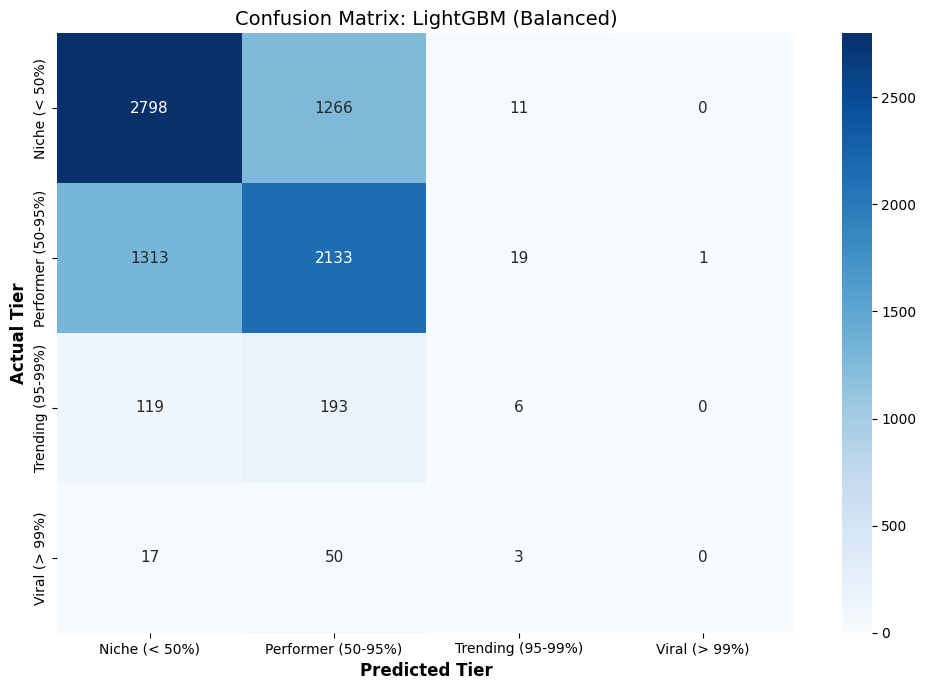

In [ ]:


# --- 1. CONFIGURE LIGHTGBM ---
# Note: LightGBM uses 'num_leaves' instead of 'max_depth'
lgbm_params = {'learning_rate': 0.16485044560925152, 'num_leaves': 60, 'min_child_samples': 44, 
               'subsample': 0.8298315525885134, 'colsample_bytree': 0.693299674599497, 'reg_alpha': 0.09193758857343017, 'reg_lambda': 5.7766296900119425,
    'n_estimators': 1000,
    'class_weight': 'balanced', # <--- BUILT-IN BALANCING! No need for external weights.
    'objective': 'multiclass',
    'num_class': 4,
    'random_state': 42,
    'n_jobs': -1
}

print("Training LightGBM Classifier...")
model_lgbm = LGBMClassifier(**lgbm_params)

# --- 2. TRAIN ---
# LightGBM is extremely fast.
model_lgbm.fit(
    X_train_model, 
    y_train_dynamic,
    eval_set=[(X_test_model, y_test_dynamic)],
    eval_metric='auc_mu', # 'auc_mu' is Multi-class AUC in LightGBM
    callbacks=[] # LightGBM generic callback placeholder (early stopping is automatic in new versions)
)

# --- 3. EVALUATE ---
preds_lgbm = model_lgbm.predict(X_test_model)

evaluate_model_performance("LightGBM (Balanced)", y_test_dynamic, preds_lgbm, target_names)

## 3.Random Forest

Training Random Forest Classifier...

PERFORMANCE REPORT: Random Forest (Balanced)
Overall Accuracy: 63.12%
-----------------------------------------------------------------------------------------------
CATEGORY                  | TOTAL ACTUAL | CORRECT HITS | HIT RATE (%) | PRECISION  | F1-SCORE  
-----------------------------------------------------------------------------------------------
Niche (< 50%)             | 4075         | 2739         | 67.21%      | 68.03%     | 0.6762
Performer (50-95%)        | 3466         | 2264         | 65.32%      | 58.14%     | 0.6152
Trending (95-99%)         | 318          | 2            | 0.63%      | 28.57%     | 0.0123
Viral (> 99%)             | 70           | 0            | 0.00%      | 0.00%     | 0.0000
-----------------------------------------------------------------------------------------------


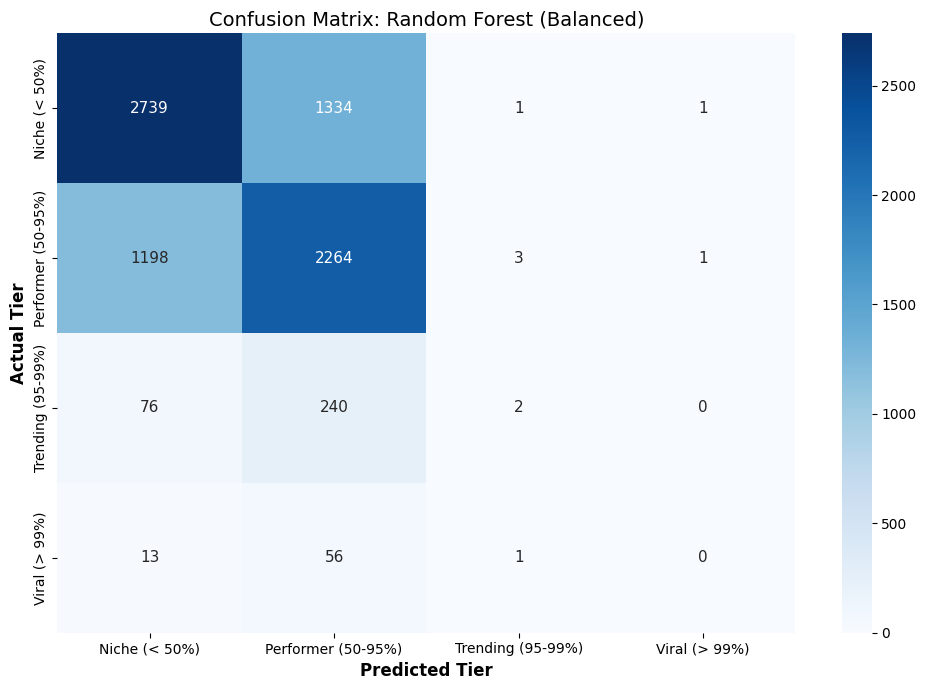

In [ ]:


# --- 1. CONFIGURE RANDOM FOREST ---
# These parameters are typical "Tuned" values for noisy data
rf_params = {
    'n_estimators': 1000,        # More trees = More stability
    'max_depth': 20,            # Deep enough to find patterns, but not infinite
    'min_samples_leaf': 4,      # Crucial: Requires 4 articles to make a rule (Filters noise)
    'max_features': 'sqrt',     # Standard for classification
    'class_weight': 'balanced', # <--- CRITICAL: Forces it to care about Viral hits
    'random_state': 42,
    'n_jobs': -1                # Use all CPU cores
}

print("Training Random Forest Classifier...")
model_rf = RandomForestClassifier(**rf_params)

# --- 2. TRAIN ---
# Random Forest does not support 'eval_set' or 'early_stopping' natively
# It trains until all trees are built.
model_rf.fit(X_train_model, y_train_dynamic)

# --- 3. EVALUATE ---
preds_rf = model_rf.predict(X_test_model)

# Use your custom evaluation function
evaluate_model_performance("Random Forest (Balanced)", y_test_dynamic, preds_rf, target_names)

## 4.Adaboost

Training AdaBoost Classifier...

PERFORMANCE REPORT: AdaBoost (Balanced Tree)
Overall Accuracy: 42.92%
-----------------------------------------------------------------------------------------------
CATEGORY                  | TOTAL ACTUAL | CORRECT HITS | HIT RATE (%) | PRECISION  | F1-SCORE  
-----------------------------------------------------------------------------------------------
Niche (< 50%)             | 4075         | 2353         | 57.74%      | 64.75%     | 0.6105
Performer (50-95%)        | 3466         | 918          | 26.49%      | 55.43%     | 0.3585
Trending (95-99%)         | 318          | 94           | 29.56%      | 6.47%     | 0.1062
Viral (> 99%)             | 70           | 38           | 54.29%      | 3.20%     | 0.0605
-----------------------------------------------------------------------------------------------


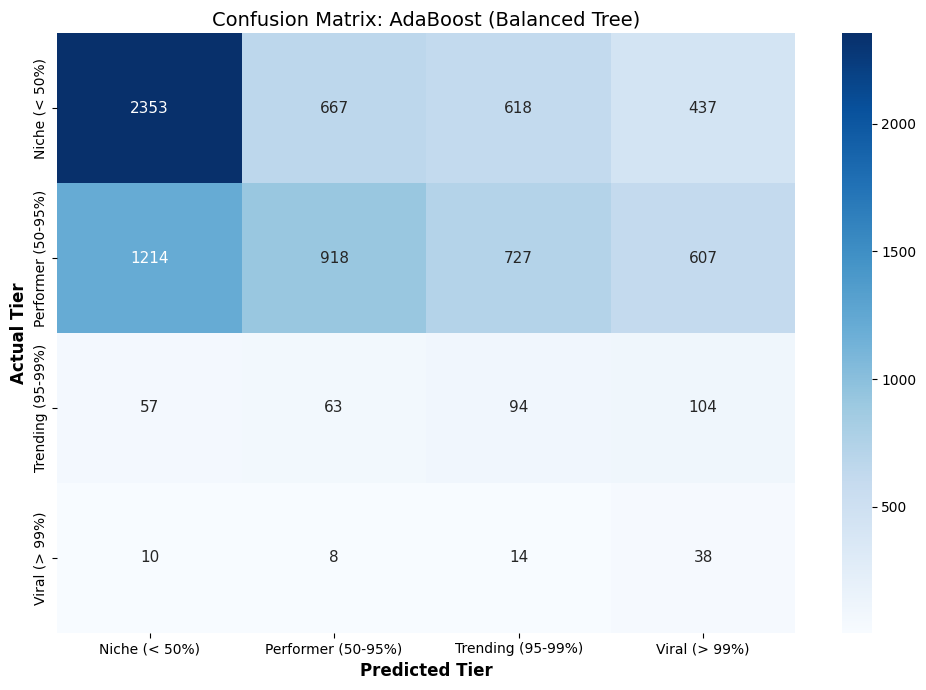

In [ ]:


# --- 1. CONFIGURE THE BASE ESTIMATOR (The Tree) ---
# Parameters like depth and leaf size go HERE
base_estimator = DecisionTreeClassifier(
    max_depth=5,                # Your value
    min_samples_leaf=18,        # Your value
    class_weight='balanced',    # Critical for Viral rarity
    random_state=42
)

# --- 2. CONFIGURE THE BOOSTER (AdaBoost) ---
# Parameters like n_estimators and learning_rate go HERE
ada_params = {
    'estimator': base_estimator,
    'n_estimators': 319,               # Your value (Moved from tree to here)
    'learning_rate': 0.08065774280726207, # Your value (Moved from tree to here)
    'algorithm': 'SAMME',
    'random_state': 42
}

print("Training AdaBoost Classifier...")
model_ada = AdaBoostClassifier(**ada_params)

# --- 3. TRAIN ---
model_ada.fit(X_train_model, y_train_dynamic)

# --- 4. EVALUATE ---
preds_ada = model_ada.predict(X_test_model)

evaluate_model_performance("AdaBoost (Balanced Tree)", y_test_dynamic, preds_ada, target_names)

## 5.Naive Bayes

Training Naive Bayes Classifier (with Power Transformation)...

PERFORMANCE REPORT: Naive Bayes (Transformed)
Overall Accuracy: 57.76%
-----------------------------------------------------------------------------------------------
CATEGORY                  | TOTAL ACTUAL | CORRECT HITS | HIT RATE (%) | PRECISION  | F1-SCORE  
-----------------------------------------------------------------------------------------------
Niche (< 50%)             | 4075         | 3327         | 81.64%      | 58.66%     | 0.6827
Performer (50-95%)        | 3466         | 1223         | 35.29%      | 61.71%     | 0.4490
Trending (95-99%)         | 318          | 25           | 7.86%      | 11.79%     | 0.0943
Viral (> 99%)             | 70           | 5            | 7.14%      | 7.94%     | 0.0752
-----------------------------------------------------------------------------------------------


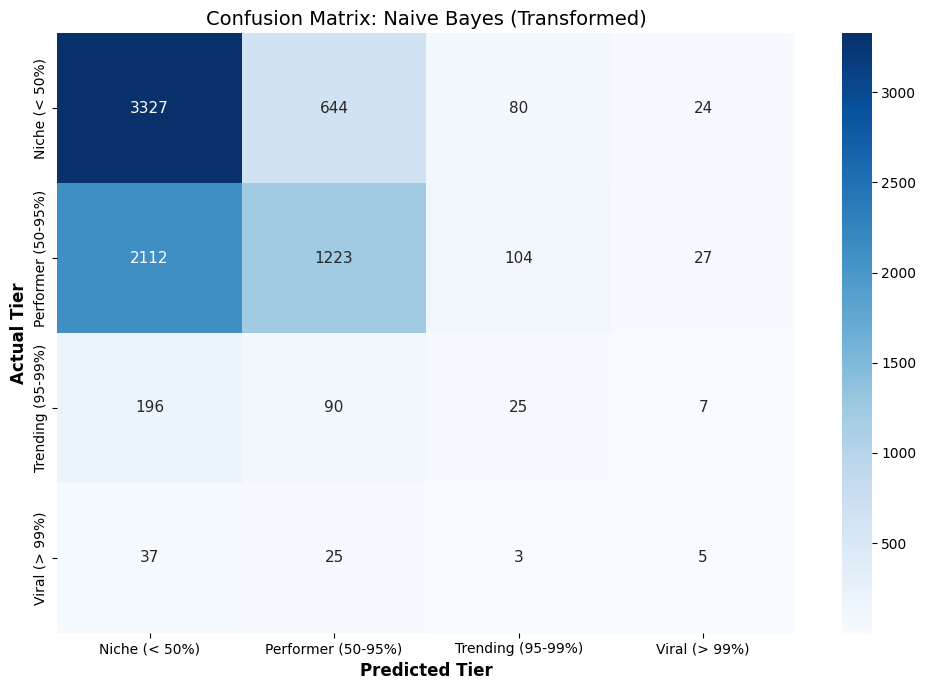

In [ ]:


# --- 1. CONFIGURE NAIVE BAYES ---
# We use a Pipeline to transform the data BEFORE the model sees it.
# PowerTransformer (Yeo-Johnson) fixes the skewness automatically.
nb_pipeline = make_pipeline(
    PowerTransformer(),  # <--- CRITICAL: Makes data "Normal" for Naive Bayes
    GaussianNB(
        var_smoothing=0.911360934123901 # Standard default, can be tuned
    )
)

print("Training Naive Bayes Classifier (with Power Transformation)...")

# --- 2. TRAIN ---
# Naive Bayes does not handle 'class_weight' natively.
# However, because it calculates probabilities based on distribution, 
# it naturally handles imbalance better than Trees in some cases.
# To force "Viral Aggression", we can use 'prior' adjustments or just rely on its nature.
nb_pipeline.fit(X_train_model, y_train_dynamic)

# --- 3. EVALUATE ---
preds_nb = nb_pipeline.predict(X_test_model)

evaluate_model_performance("Naive Bayes (Transformed)", y_test_dynamic, preds_nb, target_names)

## 6. Stacked ensemble

Building Stacking Classifier (Clean version)...


/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8453
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 58
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/yuvaraj/Library/Python/3.9/lib/python/site-packages/sklea

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8440
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8431
[LightGBM] [Info] Number of data points in the train set: 25372, number of used features: 58
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training f

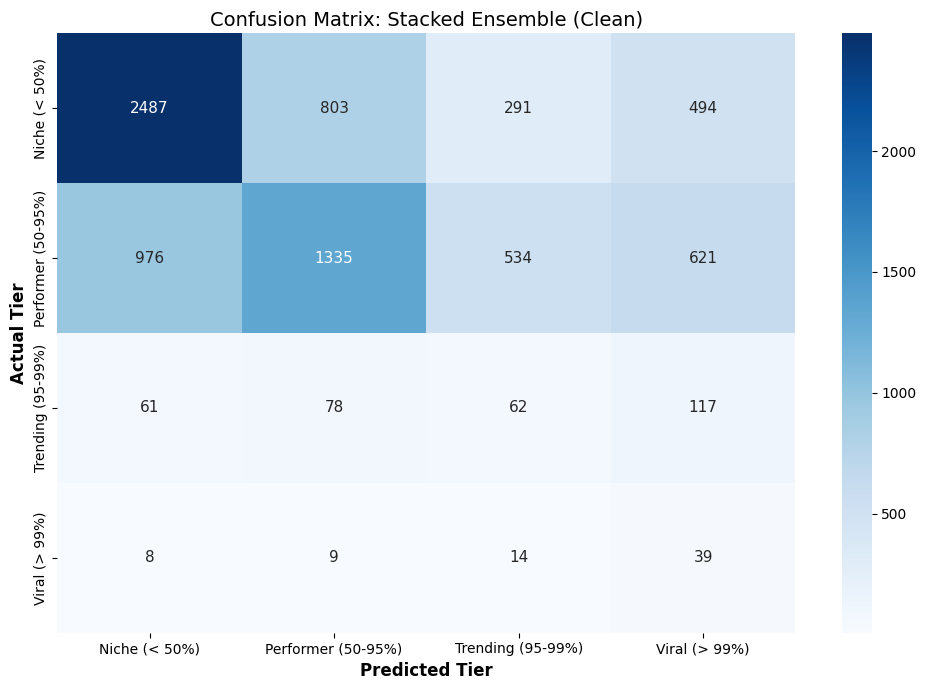

In [ ]:


# --- A. Prepare Clean XGBoost ---
# We take your tuned params but REMOVE early stopping
xgb_params_clean = model_xgb.get_params()
if 'early_stopping_rounds' in xgb_params_clean:
    del xgb_params_clean['early_stopping_rounds'] # Remove it
# Ensure n_estimators is sufficient since we can't stop early
xgb_params_clean['n_estimators'] = 500 

xgb_clean = XGBClassifier(**xgb_params_clean)

# --- B. Prepare Clean LightGBM ---
# LightGBM might have callbacks for early stopping, we need to clear them or set n_estimators
lgbm_params_clean = model_lgbm.get_params()
# Remove early stopping if it was set in constructor or just rely on fixed estimators
lgbm_clean = LGBMClassifier(**lgbm_params_clean)
lgbm_clean.set_params(n_estimators=500, early_stopping_round=None, callbacks=None)

# --- C. Define the Team ---
estimators = [
    ('xgb', xgb_clean),       # Clean version
    ('lgbm', lgbm_clean),     # Clean version
    ('rf', model_rf),         # Random Forest (doesn't use early stopping anyway)
    ('ada', model_ada),       # AdaBoost (doesn't use early stopping)
    ('nb', nb_pipeline)       # Naive Bayes (doesn't use early stopping)
]

# --- D. Define the Boss ---
final_layer = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# --- E. Build & Train Stack ---
print("Building Stacking Classifier (Clean version)...")
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_layer,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# This will now work because XGBoost won't ask for a validation set
stacking_model.fit(X_train_model, y_train_dynamic)

# --- F. Evaluate ---
print("\nPredicting with Stacked Model...")
preds_stack = stacking_model.predict(X_test_model)

evaluate_model_performance(
    "Stacked Ensemble (Clean)", 
    y_test_dynamic, 
    preds_stack, 
    target_names
)